In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [3]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [4]:
# TODO: 신고저가로 Net 비율 구하기 --> Stock Price Strength(5거래일 rolling sum 해서 비율 산출)
# TODO: 상승/하락 종목 수로 McClellan Volume Summation Index 만들기(자료 참조, Mcclellan Volume Summation Index 파일 참조)
# 미국 변수들과 1일 래깅 맞춰 주기
# tidy_data

In [5]:
tidy_data.columns

Index(['코스피 지수', '코스피 상승종목수', '코스피 하락종목수', '국고채권(3년)', '회사채(무보증3년)AA-',
       '회사채(무보증3년)BBB-', '국고채권(10년)', '뉴스심리지수(일간)', '원/달러(종가)', '코스피 신고가 종목수',
       '코스피 신저가 종목수', 'KRX 신고가 종목', 'KRX 신저가 종목', '거래량 Put', '거래량 Call',
       '일별 Put Call ratio', 'VKOSPI', 'US Gov 10Yr', '미국채 10년 이자율',
       '한국 국채 10년 이자율', '한국 CDS Spread', '코스피 거래종목 수 ', '코스닥 거래종목 수'],
      dtype='object')

In [6]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [7]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [8]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [9]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [10]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [11]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [12]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

mcclellan_df

,코스피 상승종목수,코스피 하락종목수,net advance,ratio_adjusted,19_day_EMA,39_day_EMA,EMA_diff
date,,,,,,,
2008-01-02,283.0,535.0,-252.0,-308.068460,-308.068460,-308.068460,0.000000
2008-01-03,345.0,451.0,-106.0,-133.165829,-301.209533,-305.292227,4.082694
2008-01-04,401.0,385.0,16.0,20.356234,-288.599111,-300.123204,11.524093
2008-01-07,221.0,589.0,-368.0,-454.320988,-295.098008,-302.570788,7.472780
2008-01-08,347.0,445.0,-98.0,-123.737374,-288.377983,-299.732162,11.354179
...,...,...,...,...,...,...,...
2024-05-21,292.0,588.0,-296.0,-336.363636,-35.917389,-50.520097,14.602708
2024-05-22,402.0,478.0,-76.0,-86.363636,-37.895673,-51.089042,13.193369
2024-05-23,349.0,534.0,-185.0,-209.513024,-44.625765,-53.603708,8.977943


<Axes: >

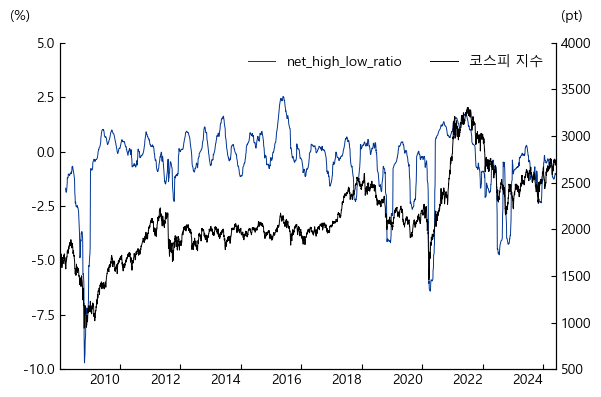

In [13]:
plot_data_df = pd.DataFrame([krx_52highlow_5days_df.net_high_low_ratio*100, kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

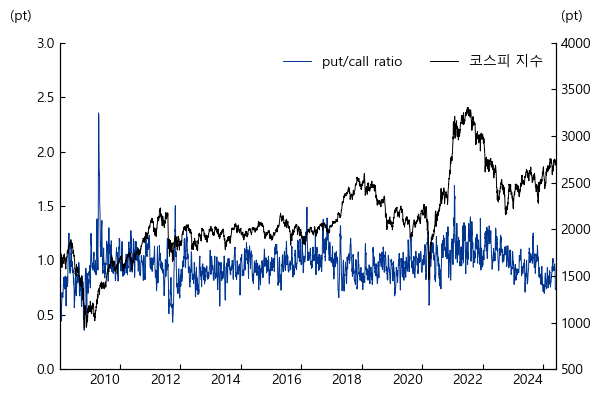

In [14]:
plot_data_df = pd.DataFrame([put_call_5d_sum['put/call ratio'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

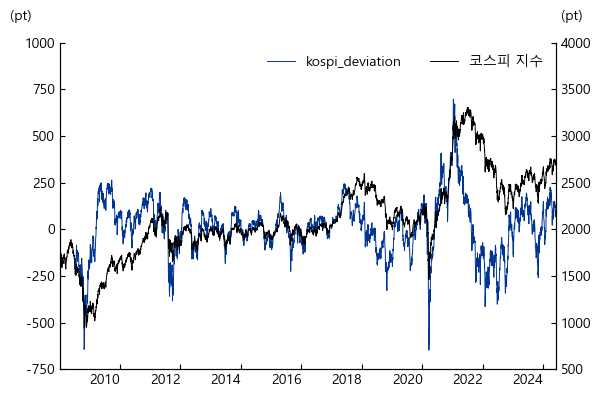

In [15]:
plot_data_df = pd.DataFrame([kospi_index_df['kospi_deviation'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

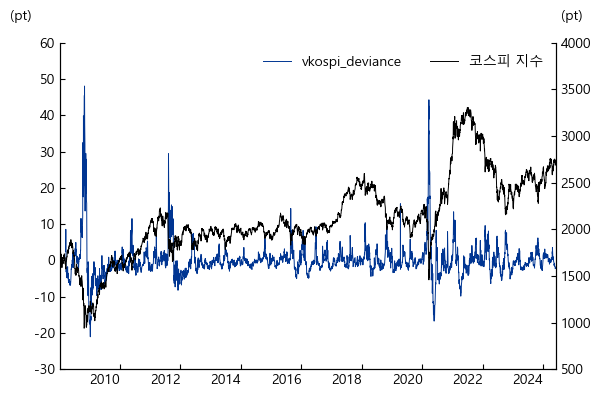

In [16]:
plot_data_df = pd.DataFrame([vkospi_df['vkospi_deviance'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

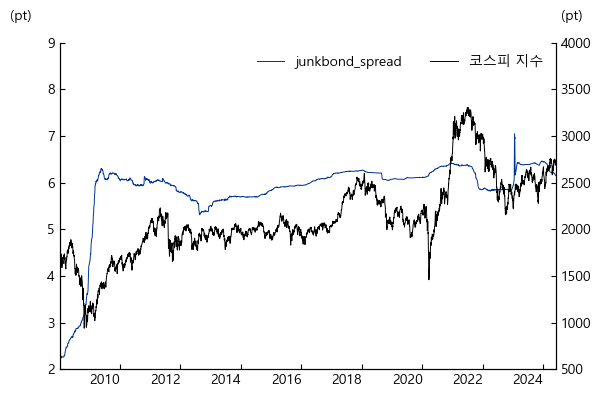

In [17]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['junkbond_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

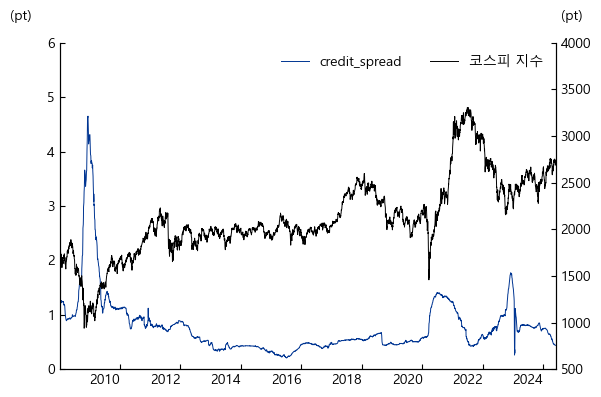

In [18]:
plot_data_df = pd.DataFrame([junk_bond_spread_df['credit_spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

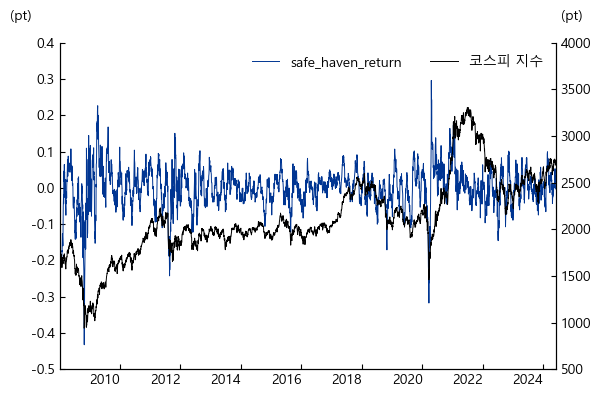

In [19]:
plot_data_df = pd.DataFrame([safe_haven_demand_df['safe_haven_return'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



date
2008-01-02         NaN
2008-01-03         NaN
2008-01-04         NaN
2008-01-07         NaN
2008-01-08         NaN
                ...   
2024-05-21   -1.057287
2024-05-22   -1.002850
2024-05-23   -1.002157
2024-05-24   -1.019351
2024-05-27   -1.033441
Name: net_high_low_ratio, Length: 4052, dtype: float64

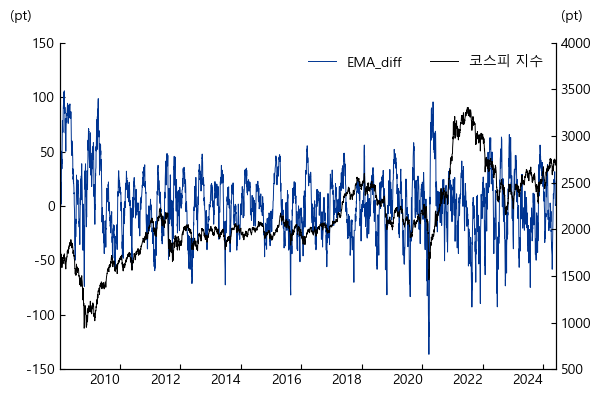

In [20]:
plot_data_df = pd.DataFrame([mcclellan_df['EMA_diff'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)
krx_52highlow_5days_df.net_high_low_ratio*100


<Axes: >

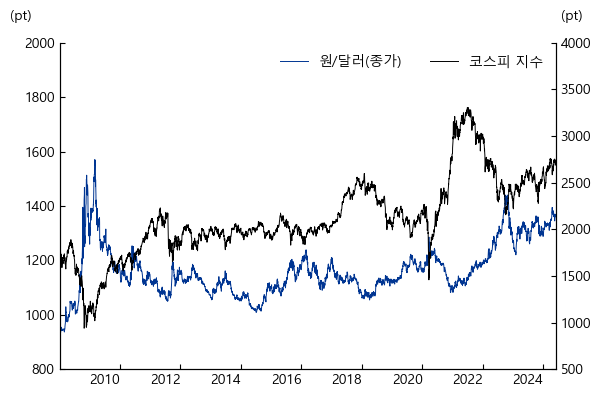

In [21]:
plot_data_df = pd.DataFrame([tidy_data['원/달러(종가)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

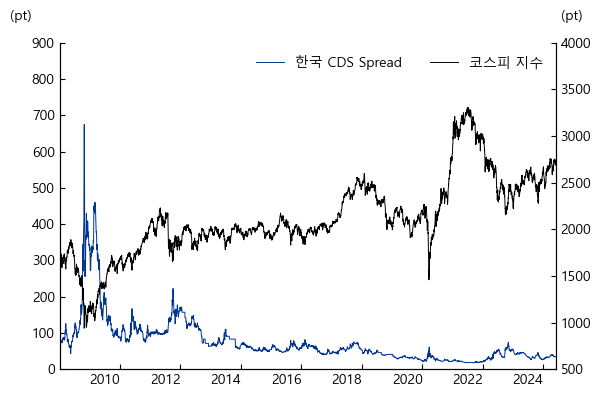

In [22]:
plot_data_df = pd.DataFrame([tidy_data['한국 CDS Spread'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)


<Axes: >

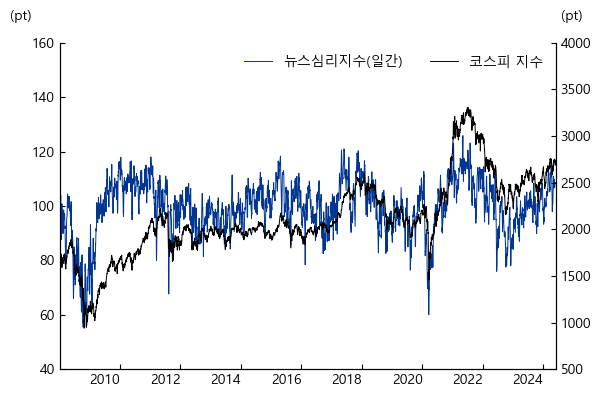

In [23]:
plot_data_df = pd.DataFrame([tidy_data['뉴스심리지수(일간)'], kospi_index_df['코스피 지수']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)



<Axes: >

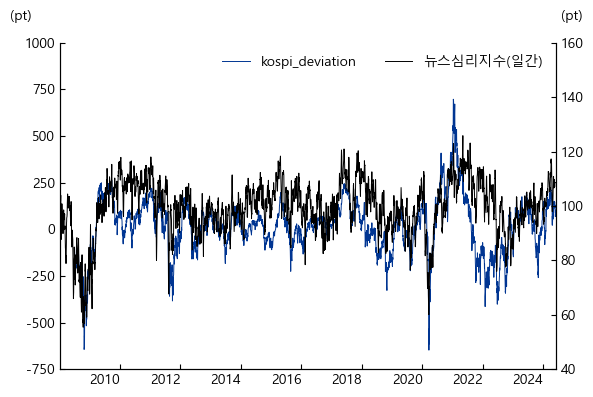

In [24]:
plot_data_df = pd.DataFrame([kospi_index_df['kospi_deviation'], tidy_data['뉴스심리지수(일간)']]).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [25]:
data_name_list = ['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread', 'credit_spread', 'safe_haven_return', 'EMA_diff',
                  'USD/KRW', 'KR_CDS_spread']
whole_data_df = pd.DataFrame([
        put_call_5d_sum['put/call ratio'],
        kospi_index_df['kospi_deviation'],
        vkospi_df['vkospi_deviance'],
        junk_bond_spread_df['junkbond_spread'],
        junk_bond_spread_df['credit_spread'],
        safe_haven_demand_df['safe_haven_return'],
        mcclellan_df['EMA_diff'],
        tidy_data['원/달러(종가)'],
        tidy_data['한국 CDS Spread'],
    ], index = data_name_list)

whole_data_df = whole_data_df.T

In [244]:
def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

# FIXME: 
mean_values = standardized_df.T.mean().T * 50 + 50

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

# 그냥 지수
normalized_mean_values = mean_values
# 100으로 변환 되도록 바꿈
normalized_mean_values = normalize_series(mean_values) *100

<Axes: >

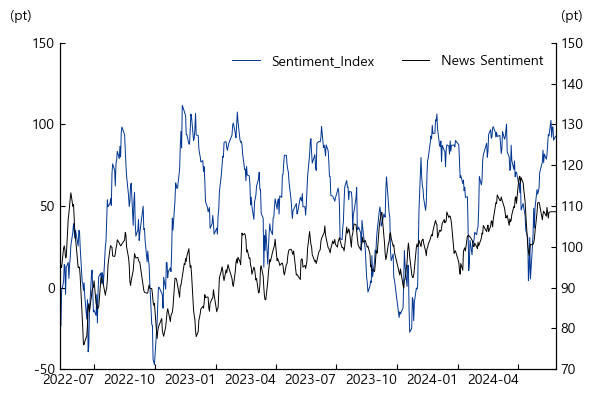

In [245]:
last_plot_n = 504
plot_data_df = pd.DataFrame([mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

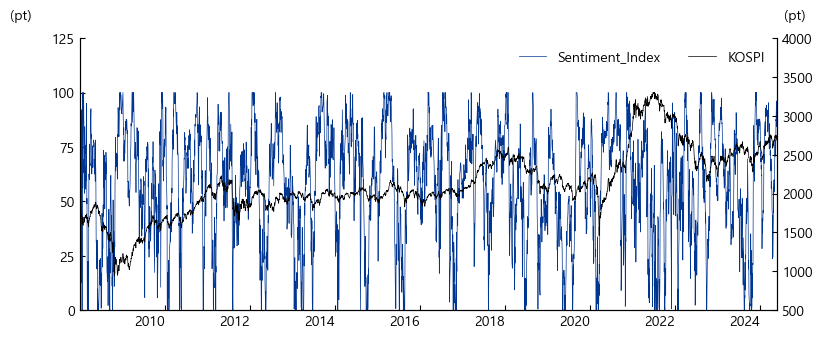

In [255]:
last_plot_n = 5000
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', 'KOSPI']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.5)

<Axes: >

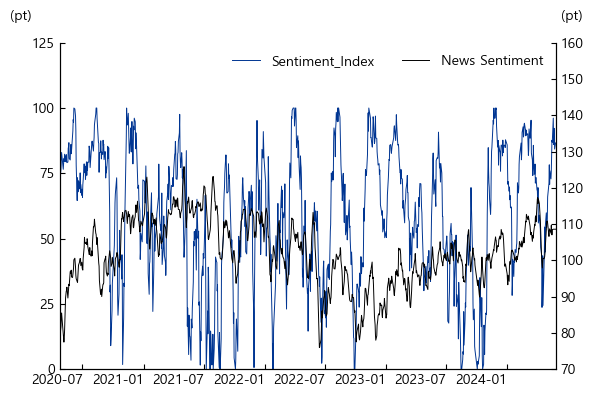

In [201]:
last_plot_n = 1008
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

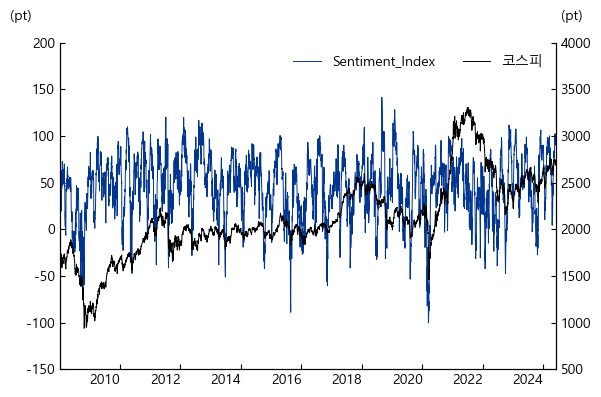

In [243]:
last_plot_n = 6000
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', '코스피']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [205]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.4235
Date:                Thu, 06 Jun 2024   Prob (F-statistic):              0.515
Time:                        15:44:51   Log-Likelihood:                -10609.
No. Observations:                3529   AIC:                         2.122e+04
Df Residuals:                    3527   BIC:                         2.124e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8004      0.703      1.139      0.2

<Axes: >

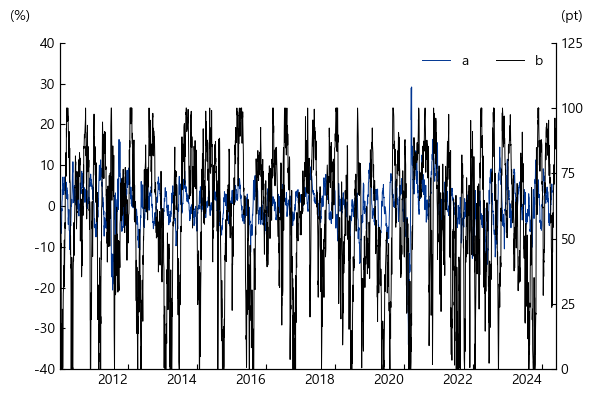

In [206]:
last_plot_n = 1000
plot_data_df = df[['a','b']].copy()
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [207]:
## TODO: 그림상으로 봤을 때 낮은 구간이랑 높은 구간이랑 차이가 있음
## (낮은 구간에서는 저가매수, 높은 구간에서는 모멘텀으로 더 올라가는 경우가 발생함)
df

,a,b,ef_dummy,f_dummy,n_dummy,g_dummy,eg_dummy
date,,,,,,,
2010-01-04,-4.782624,75.722112,0,0,0,1,0
2010-01-05,-4.388922,79.057555,0,0,0,1,0
2010-01-06,-8.104051,93.363041,0,0,0,0,1
2010-01-07,-7.761442,80.923236,0,0,0,0,1
2010-01-08,-7.359933,88.829527,0,0,0,0,1
...,...,...,...,...,...,...,...
2024-05-21,NaN,86.014250,0,0,0,0,1
2024-05-22,NaN,92.128273,0,0,0,0,1
2024-05-23,NaN,92.222413,0,0,0,0,1


<Axes: xlabel='a', ylabel='b'>

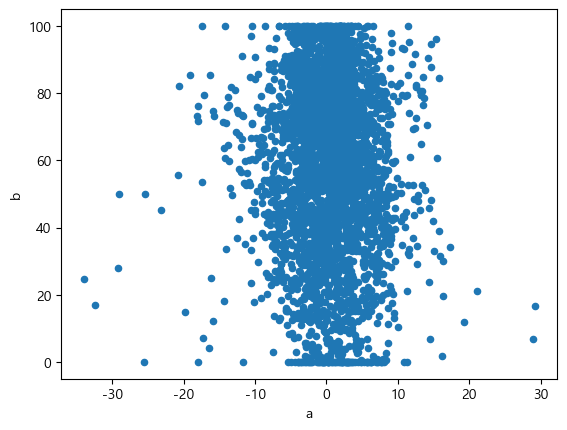

In [208]:
plot_data_df.plot.scatter(x='a', y='b')

In [212]:
#### PCA 결과

def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

mean_values = standardized_df.T.mean().T * 50 + 50

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

# 그냥 지수
normalized_mean_values = mean_values
# 100으로 변환 되도록 바꿈
# normalized_mean_values = normalize_series(mean_values) *100

In [213]:
# 최근 4년
pca_feature_df = standardized_df.dropna().iloc[1000:,:]
n_principal_component = 1
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1'])
principalDf = -principalDf
principal_vectors = - pca.components_


print(principal_vectors)
print(standardized_df.columns)



[[ 0.07915455  0.42693716  0.28407951 -0.17218822  0.29461563  0.35312193
   0.31729553  0.43635081  0.44557527]]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


In [214]:
principalDf

,principal component1
0,2.409858
1,2.126515
2,1.619191
3,1.031551
4,1.067577
...,...
2922,1.484104
2923,1.645688
2924,1.379823
2925,0.693747


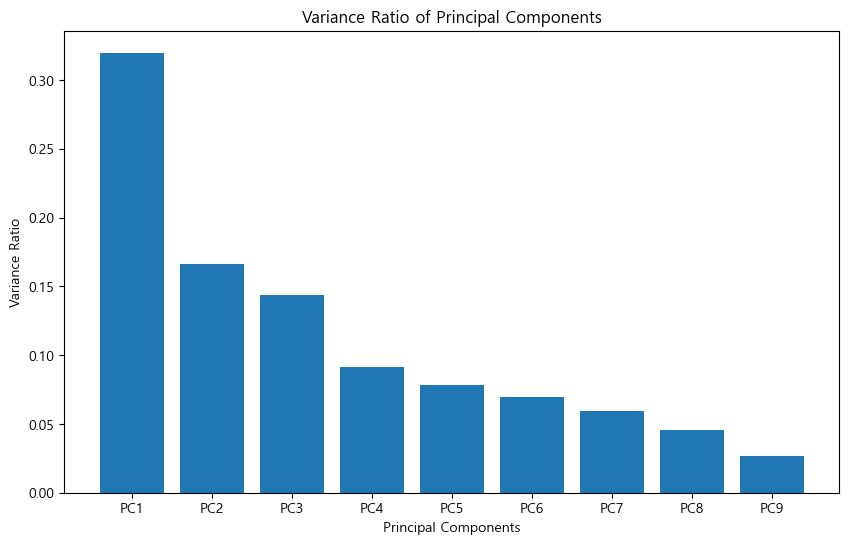

In [215]:
# 전체 기간
pca_feature_df = standardized_df.dropna()
n_principal_component = 9
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                                                'PC6', 'PC7', 'PC8', 'PC9'])
principal_vectors = - pca.components_

# 고유값과 고유값 비율 계산
eigenvalues = pca.explained_variance_
eigenvalue_ratios = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_principal_component + 1), eigenvalue_ratios, tick_label=[f'PC{i}' for i in range(1, n_principal_component + 1)])
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio of Principal Components')
plt.show()

In [216]:
# 전체 기간
pca_feature_df = standardized_df.dropna()
n_th_pc = 1
n_principal_component = 9
from sklearn.decomposition import PCA
pca = PCA(n_components=n_principal_component) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(pca_feature_df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                                                                'PC6', 'PC7', 'PC8', 'PC9'])

principalDf = -principalDf.iloc[:, n_th_pc-1]
principalDf.index = pca_feature_df.index
principal_vectors = - pca.components_


print(principal_vectors[0, :])
print(standardized_df.columns)

[-0.02253051  0.43574972  0.29090684 -0.12903808  0.28268422  0.3596675
  0.30567102  0.44008241  0.46038958]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


<Axes: >

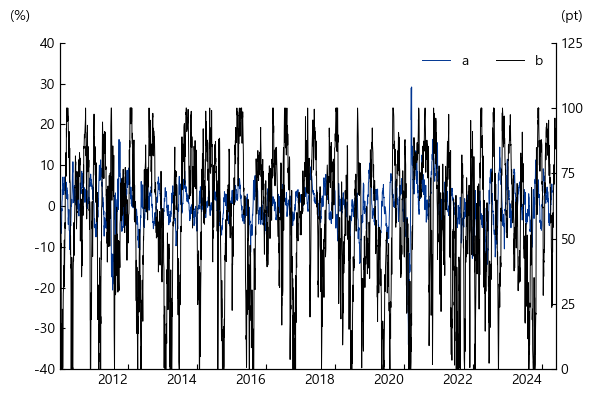

In [217]:
principalDf.index = pca_feature_df.index
# print(pd.DataFrame(mean_values).head())
# print(principalDf.head())
plot_df = pd.merge(pd.DataFrame(mean_values),principalDf, left_index=True, right_index=True)
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

In [271]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 1
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = principalDf * 10 + 65



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                    0.4296
Date:                Thu, 06 Jun 2024   Prob (F-statistic):              0.512
Time:                        18:08:27   Log-Likelihood:                -13086.
No. Observations:                3425   AIC:                         2.618e+04
Df Residuals:                    3423   BIC:                         2.619e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3165      3.545      1.218      0.2

<Axes: >

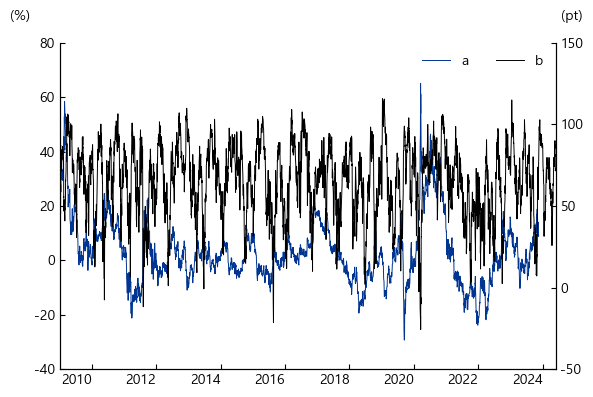

In [257]:
plot_data_df = df[['a','b']].copy()
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

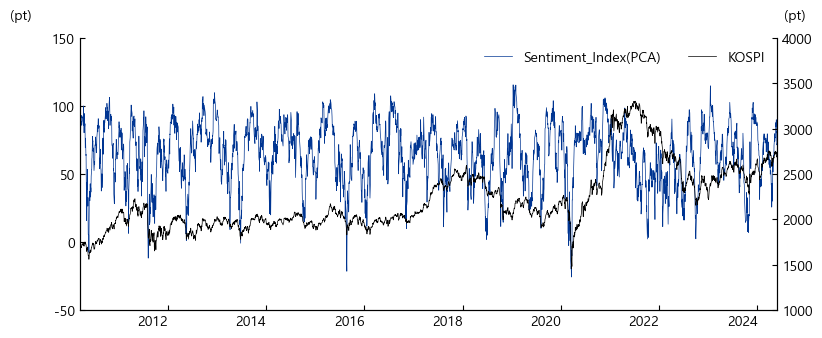

In [261]:
last_plot_n = 3500
plot_data_df = pd.DataFrame([df['b'][-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index(PCA)', 'KOSPI']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.5)

PLS Index:
date
2010-06-29    0.129318
2010-06-30    0.091632
2010-07-01    0.153660
2010-07-02    0.408833
2010-07-05    0.349644
dtype: float64
date
2024-05-21    0.374628
2024-05-22    0.160519
2024-05-23    0.115224
2024-05-24    0.163888
2024-05-27    0.339330
dtype: float64

PLS Vectors:
                   0         1         2         3         4         5  \
date                                                                     
2010-06-29  0.196697 -0.524466 -0.188936  0.585495 -0.055590 -0.163237   
2010-06-30  0.195963 -0.527812 -0.186318  0.589934 -0.062728 -0.147115   
2010-07-01  0.195805 -0.530101 -0.183911  0.592360 -0.068351 -0.138092   
2010-07-02  0.196643 -0.531437 -0.182422  0.593380 -0.072320 -0.132577   
2010-07-05  0.197963 -0.532313 -0.181977  0.594221 -0.076518 -0.127152   

                   6         7         8  
date                                      
2010-06-29 -0.446707  0.227746  0.163072  
2010-06-30 -0.443993  0.224451  0.164891  
2010-07-01 -0.

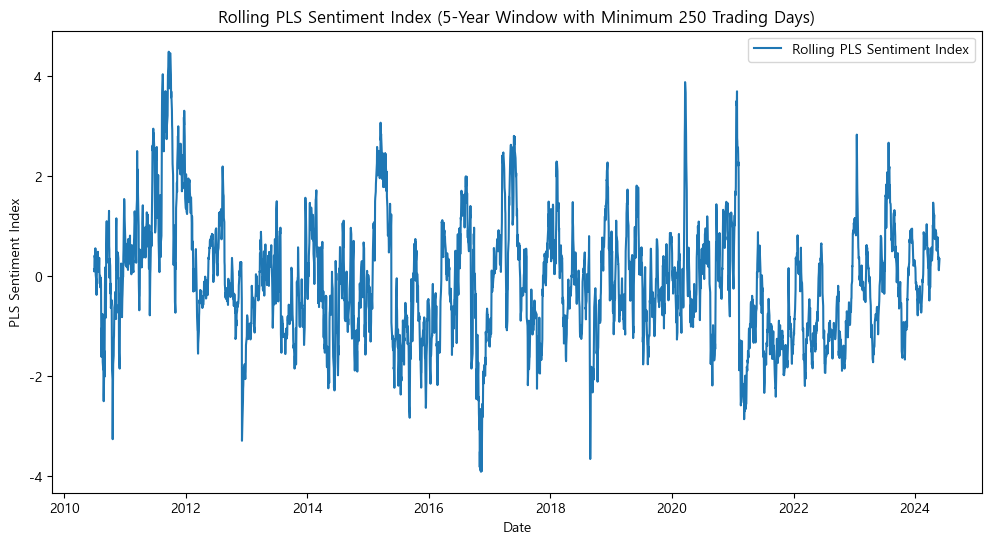

In [44]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pls_feature_df = standardized_df.dropna()

# 예제 데이터 생성
dates = pls_feature_df.index  # 3000 거래일 데이터
features = pls_feature_df
target = kospi_index_df['코스피 지수'].copy()

start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

features = features.loc[features.index > start_date_dt]
target = target.loc[target.index > start_date_dt]


# Rolling window PLS 생성 함수
def rolling_pls(X, y, fitting_window, target_window, min_window=250, n_components=1):
    indices = X.index
    pls_indices = []
    pls_vectors = []
    
    for end in range(min_window + target_window, len(X) + 1):
        start = max(end - target_window - fitting_window, 0)
        if end - start < min_window:
            continue
        
        X_window = X.iloc[start:end - target_window]
        y_window = y.iloc[start + target_window:end]
        
        if len(X_window) != len(y_window):
            continue
        
        # 데이터 표준화
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X_window)
        y_scaled = scaler_y.fit_transform(y_window.values.reshape(-1, 1)).ravel()
        
        # PLS 모델 생성 및 학습
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_scaled, y_scaled)
        
        # PLS 인덱스 생성
        X_transformed = pls.transform(scaler_X.transform(X.iloc[end-1:end]))[0, 0]
        pls_indices.append(X_transformed)
        
        # PLS 벡터 저장
        pls_vector = pls.x_weights_[:, 0]
        pls_vectors.append(pls_vector)
    
    pls_series = pd.Series(pls_indices, index=indices[min_window + target_window - 1:])
    pls_vectors_df = pd.DataFrame(pls_vectors, index=indices[min_window + target_window - 1:])
    
    return pls_series, pls_vectors_df

# 기간 설정 (일 기준)
fitting_window = 250 * 5  # 5년 = 250일 * 5
target_window = 125  # 1년 = 250일
min_window = 250  # 최소 250 거래일

# Rolling PLS Sentiment Index 및 PLS 벡터 생성
pls_index, pls_vectors = rolling_pls(features, target, fitting_window, target_window, min_window)

# 결과 출력
print("PLS Index:")
print(pls_index.head())
print(pls_index.tail())

print("\nPLS Vectors:")
print(pls_vectors.head())
print(pls_vectors.tail())

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pls_index, label='Rolling PLS Sentiment Index')
plt.xlabel('Date')
plt.ylabel('PLS Sentiment Index')
plt.title('Rolling PLS Sentiment Index (5-Year Window with Minimum 250 Trading Days)')
plt.legend()
plt.show()


<Axes: xlabel='date'>

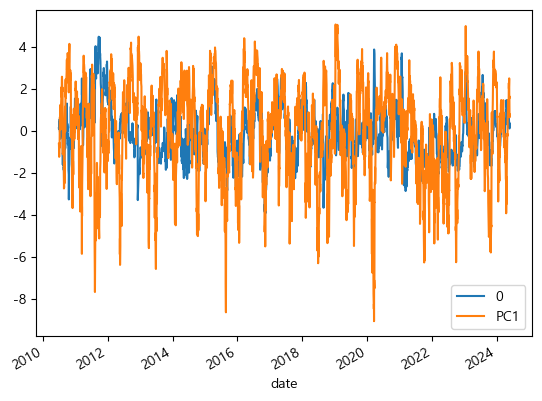

In [45]:
plot_df = pd.merge(pd.DataFrame(pls_index),principalDf, left_index=True, right_index=True)
plot_df.plot()

<Axes: xlabel='0', ylabel='PC1'>

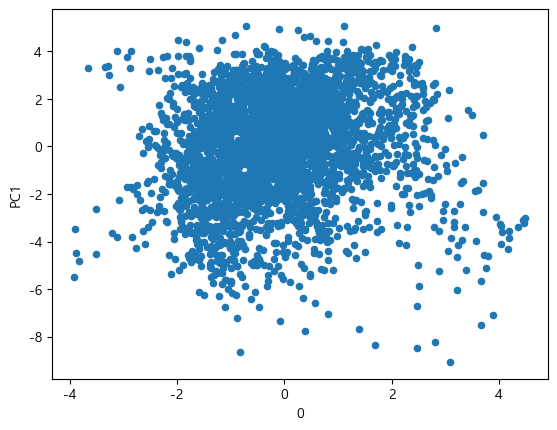

In [46]:
plot_df.plot.scatter(x=0, y='PC1')

PLS Index:
date
2009-12-29   -0.669835
2009-12-30   -0.705532
2010-01-04   -0.766433
2010-01-05   -0.751205
2010-01-06   -0.463142
dtype: float64
date
2024-05-21    0.341803
2024-05-22    0.047186
2024-05-23   -0.134792
2024-05-24    0.040274
2024-05-27    0.063365
dtype: float64

PLS Vectors:
                   0         1         2         3         4         5  \
date                                                                     
2009-12-29 -0.373692  0.333974  0.224750 -0.335876  0.393826  0.282894   
2009-12-30 -0.373073  0.329245  0.217175 -0.350361  0.389660  0.284615   
2010-01-04 -0.372706  0.324812  0.207835 -0.364424  0.386524  0.283003   
2010-01-05 -0.370640  0.319533  0.198339 -0.376518  0.383125  0.287515   
2010-01-06 -0.368959  0.314217  0.190216 -0.387658  0.379734  0.291670   

                   6         7         8  
date                                      
2009-12-29  0.557651  0.127640  0.151971  
2009-12-30  0.558194  0.125527  0.149397  
2010-01-04  0.

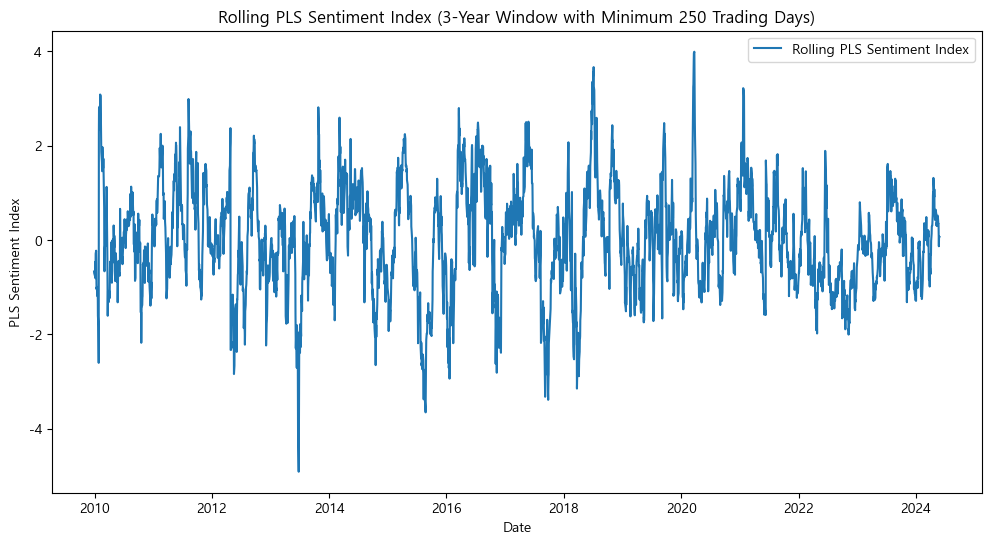

In [72]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import datetime as dt

# 예제 데이터 준비
pls_feature_df = standardized_df.dropna()



start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

features = features.loc[features.index > start_date_dt]
target = target.loc[target.index > start_date_dt]

# Rolling window PLS 생성 함수
def rolling_pls(X, y, fitting_window, target_window, min_window=250, n_components=1):
    indices = X.index
    pls_indices = []
    pls_vectors = []
    previous_vector = None
    
    for end in range(min_window + target_window, len(X) + 1):
        start = max(end - target_window - fitting_window, 0)
        if end - start < min_window:
            continue
        
        X_window = X.iloc[start:end - target_window]
        y_window = y.iloc[start + target_window:end]
        
        if len(X_window) != len(y_window):
            continue
        
        # 이미 표준화된 데이터 사용
        X_scaled = X_window.values
        y_scaled = y_window.values.reshape(-1, 1)
        
        # PLS 모델 생성 및 학습
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_scaled, y_scaled)
        
        # PLS 인덱스 생성
        X_transformed = pls.transform(X.iloc[end-1:end].values)[0, 0]
        pls_indices.append(X_transformed)
        
        # PLS 벡터 저장 및 방향 조정
        pls_vector = pls.x_weights_[:, 0]
        if previous_vector is not None:
            if np.dot(previous_vector, pls_vector) < 0:
                pls_vector = -pls_vector
        previous_vector = pls_vector
        pls_vectors.append(pls_vector)
    
    pls_series = pd.Series(pls_indices, index=indices[min_window + target_window - 1:])
    pls_vectors_df = pd.DataFrame(pls_vectors, index=indices[min_window + target_window - 1:])
    
    return pls_series, pls_vectors_df

# 기간 설정 (일 기준)
fitting_window = 250 * 3  # 3년 = 250일 * 3
target_window = 125  # 6개월 = 125일
min_window = 250  # 최소 250 거래일

# 날짜 및 데이터 필터링
dates = pls_feature_df.index
features = pls_feature_df
target = kospi_index_df['코스피 지수'].pct_change(periods=target_window)
target = target.rolling(window=120, min_periods=1).mean()
# Rolling PLS Sentiment Index 및 PLS 벡터 생성
pls_index, pls_vectors = rolling_pls(features, target, fitting_window, target_window, min_window)

# 결과 출력
print("PLS Index:")
print(pls_index.head())
print(pls_index.tail())

print("\nPLS Vectors:")
print(pls_vectors.head())
print(pls_vectors.tail())

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pls_index, label='Rolling PLS Sentiment Index')
plt.xlabel('Date')
plt.ylabel('PLS Sentiment Index')
plt.title('Rolling PLS Sentiment Index (3-Year Window with Minimum 250 Trading Days)')
plt.legend()
plt.show()


PLS Index:
[-0.39039728 -0.33066502 -0.04031533  0.15656572 -0.06481715]
[1.29447053 1.24178673 1.45746266 1.43134179 1.38901891]

PLS Vector:
[ 0.36118451 -0.18259794  0.24238506  0.72860726  0.07672553  0.26939553
  0.26108466 -0.12780646  0.28917855]
Index(['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread',
       'credit_spread', 'safe_haven_return', 'EMA_diff', 'USD/KRW',
       'KR_CDS_spread'],
      dtype='object')


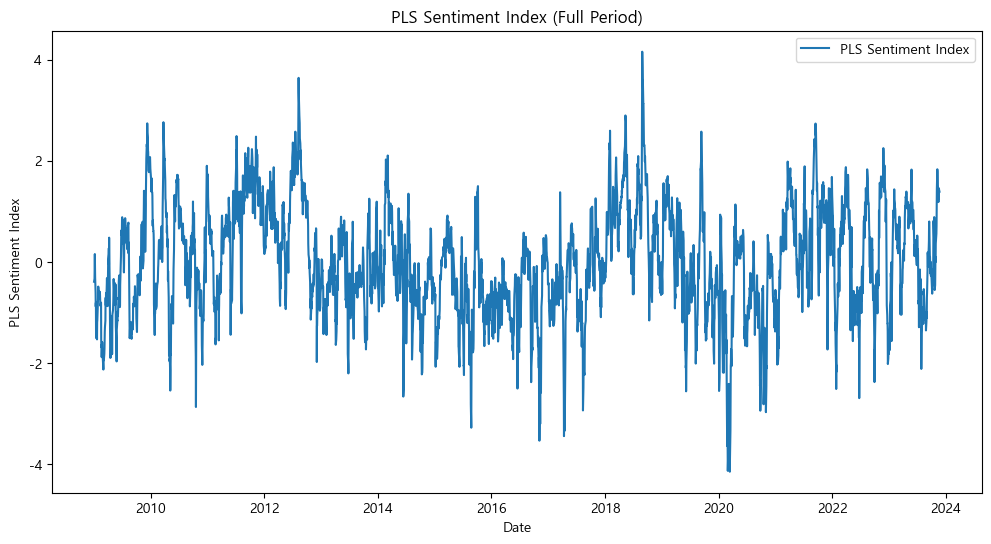

In [262]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import datetime as dt

# 예제 데이터 준비
pls_feature_df = standardized_df.dropna()
target = kospi_index_df['코스피 지수'].copy()

# 날짜 및 데이터 필터링
dates = pls_feature_df.index
features = pls_feature_df

n_day = 125
# Rolling mean을 계산하고 NaN 값 처리
# target = target.rolling(window=n_day, min_periods=1).mean()
target = target.pct_change(periods=n_day)
target = target.shift(-n_day)

# 시작 날짜 필터링
start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

end_date_str = '2025-01-01'
end_date_dt = dt.datetime.strptime(end_date_str, '%Y-%m-%d')

features = features.loc[features.index > start_date_dt]
target = target.loc[target.index > start_date_dt]

features = features.loc[features.index < end_date_dt]
target = target.loc[target.index < end_date_dt]

# features와 target의 공통 날짜 필터링
target = target.dropna()
common_dates = features.index.intersection(target.index)
features = features.loc[common_dates]
target = target.loc[common_dates]


# PLS 모델 생성 및 학습
pls = PLSRegression(n_components=1)
pls.fit(features.values, target.values.reshape(-1, 1))

# PLS 인덱스 생성
pls_index = pls.transform(features.values).flatten()

# PLS 벡터 저장
pls_vector = pls.x_weights_[:, 0]

# 결과 출력
print("PLS Index:")
print(pls_index[:5])
print(pls_index[-5:])

print("\nPLS Vector:")
print(pls_vector)

print(standardized_df.columns)

# PLS 인덱스를 시리즈로 변환하여 인덱스 설정
pls_index = pd.Series(pls_index, index=features.index)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pls_index, label='PLS Sentiment Index')
plt.xlabel('Date')
plt.ylabel('PLS Sentiment Index')
plt.title('PLS Sentiment Index (Full Period)')
plt.legend()
plt.show()


<Axes: xlabel='date'>

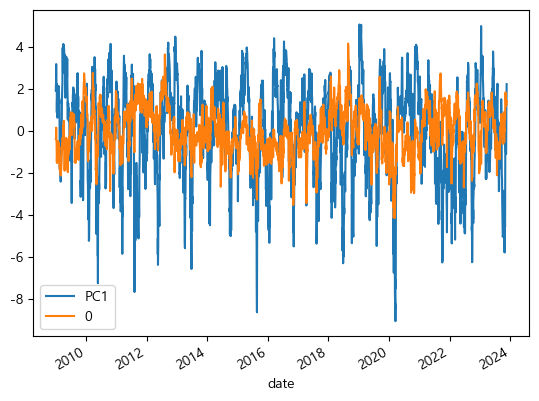

In [263]:
plot_df = pd.merge(principalDf,pd.DataFrame(pls_index), left_index=True, right_index=True)
plot_df.plot()

<Axes: xlabel='0', ylabel='PC1'>

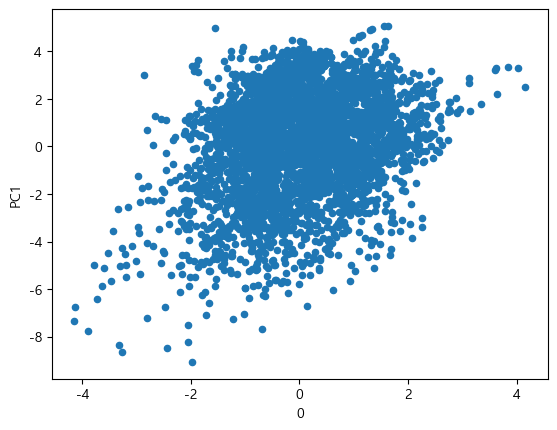

In [264]:
plot_df.plot.scatter(x=0, y='PC1')

In [272]:
### 기간별 수익률 만들기

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 60
lag = 0
cal_lag = window_size + lag
start_date_str = '2009-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)

sentiment_index = pd.Series(-standardized_df @ -pls_vector, index=standardized_df.index)
sentiment_index = sentiment_index * 10 + 65
# sentiment_index = pls_index * 10 + 50

df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + f_dummy + n_dummy + g_dummy + eg_dummy + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ 1 + b + b*f_dummy+ b*n_dummy+ b*g_dummy+ b*eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ ef_dummy + f_dummy + n_dummy + g_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# reg = smf.ols('a ~ -1 + ef_dummy + f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
# print(reg.summary())
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     9.875
Date:                Thu, 06 Jun 2024   Prob (F-statistic):            0.00169
Time:                        18:10:59   Log-Likelihood:                -12914.
No. Observations:                3744   AIC:                         2.583e+04
Df Residuals:                    3742   BIC:                         2.584e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5262      3.152      3.340      0.0

<Axes: >

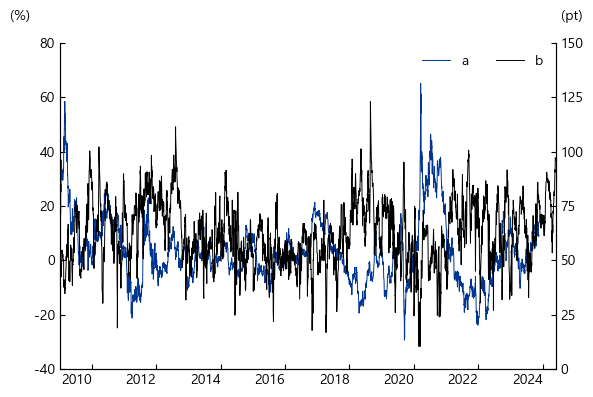

In [269]:
plot_data_df = df[['a','b']].copy()
plot_multi(data=plot_data_df, unit_list=['(%)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

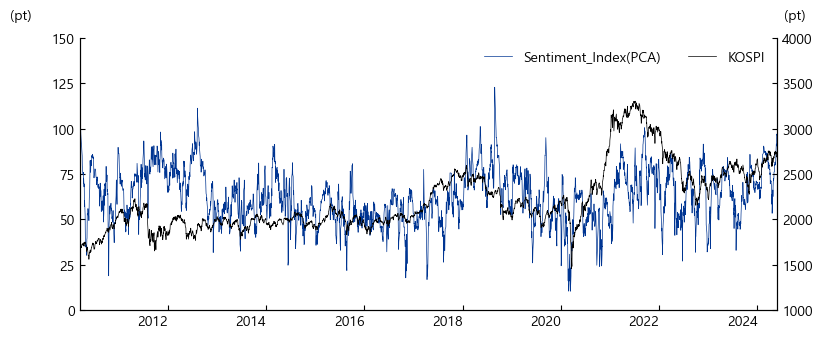

In [270]:
last_plot_n = 3500
plot_data_df = pd.DataFrame([df['b'][-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index(PLS)', 'KOSPI']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.5)

In [156]:
df

,a,b,ef_dummy,f_dummy,n_dummy,g_dummy,eg_dummy
date,,,,,,,
2019-01-02,9.761194,50.164155,0,0,1,0,0
2019-01-03,10.590861,35.545491,0,1,0,0,0
2019-01-04,9.611242,48.136172,0,0,1,0,0
2019-01-07,8.164548,56.076011,0,0,1,0,0
2019-01-08,7.494309,73.684154,0,0,0,1,0
...,...,...,...,...,...,...,...
2024-05-21,NaN,74.399080,0,0,0,1,0
2024-05-22,NaN,77.628490,0,0,0,1,0
2024-05-23,NaN,77.281790,0,0,0,1,0
